<p><img src="https://github.com/profLewis/Geog2021_Coursework/blob/master/images/ucl_logo.png?raw=true" align="left" \><img src="https://www.nceo.ac.uk/wp-content/themes/nceo/assets/images/logos/img_logo_purple.svg" align="right" /></p>

# Visualización rápida de datos de Sentinel 2 sobre Colombia
### J Gómez-Dans (NCEO & UCL)

Este *notebook* contiene una forma rápida de extraer y analizar datos del satélite Sentinel-2. Es una pequeña demostración con una extensión regional limitada (en este caso sólo una tesela, equivalente a unos 100x100 km en el terreno), pero que permite ver una propuesta de acceso a los datos. Los datos han sido pre-procesados y están almacenados en el servidor de UCL, de dónde se descargan bajo demanda. Esto libra al usuario de necesitar un ordenador potente y disco.

Como ejemplo, hemos tomado una zona rectangular alrededor de la ciudad de Aguadas, pero el usuario es libre de definir su propia región de interés (ROI), y bien enlazarla en el código más abajo, o subirla y utilizarla. Las zonas de interés se pueden editar fácilmente usando [GeoJSON.io](https://geojson.io), or [Google My Maps](https://www.google.com/mymaps), aunque también se puede subir un sufrido shapefile.

Como los datos están almacenados en un servidor remoto, extraerlos puede demorarse un poco (esperamos que menos de un minutos, pero... hay un montón de imágenes!). Ten paciencia!

La celda siguiente crea una base de datos de las imágenes disponibles en el servidor de UCL, y nos da una idea de cuántos datos hay: 115 imágenes entre el 2 de Enero de 2018 y el 30 de Diciembre. Desgraciadamente, hay muchas nubes, pero es lo que hay. Si estás faimilarizado con Python, `img_db` es un diccionario indexado por fechas, y que asocia a cada fecha las URLs de los ficheros que contienen los datos para todas las bandas del sensor y la máscara de nubes.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import gdal
gdal.UseExceptions()   

from utils import grab_holdings, extract_roi_data_ndre

img_db = grab_holdings(
    url="http://www2.geog.ucl.ac.uk/~ucfajlg/Colombia/database.json")
print(f"Primera adquisición: {list(img_db.keys())[0].strftime('%d %b %Y'):s}")
print(f"Última adquisición: {list(img_db.keys())[-1].strftime('%d %b %Y'):s}")
print(f"Número total de adquisiciones: {len(img_db.keys()):d}, aunque hay nubes a dolor!")

Primera adquisición: 02 Jan 2018
Última adquisición: 30 Dec 2018
Número total de adquisiciones: 115, aunque hay nubes a dolor!




El siguiente paso es visualizar los datos. Los datos "crudos" son reflectancia de superficie, y también tenemos una máscara de nubes (también hay estimaciones de vapor de agua en la atmósfera y aerosoles, para los enfermos que lo quieran ver ;D). Podemos calcular un índice de vegetación sobre la región de interés y ver cómo va evolucionando a lo largo del año. Para ello, vamos a considerar todos los píxeles que caen dentro de la caja espacial definida por un [fichero GeoJSOn](https://gist.github.com/jgomezdans/bf202f1f0028c454ccc1ba85443414cb/raw/e25580e4afb2402532619ce196494eb907472708/aguadas.geojson).

Al correr la siguiente celda, saldrá una barra de progreso, y con suerte, no dará ningún error ;-)

Si estás familiarizado con Python `analysis_data` es un diccionario indexado por fechas, y que a cada fecha tiene asociado un *raster* con el valor del índice. Las adquisicions con nubes o sin datos ya se descartan durante el proceso.


In [7]:
roi="https://gist.github.com/jgomezdans/bf202f1f0028c454ccc1ba85443414cb/raw" + \
    "/e25580e4afb2402532619ce196494eb907472708/aguadas.geojson"
analysis_data = extract_roi_data_ndre(img_db, roi=roi)
print(f"Número de imágenes con algún pixel factible {len(list(analysis_data.keys())):d}")


Número de imágenes con algún pixel factible 56


Bueno, más o menos, la mitad de las imágenes son utilizables. Vamos a ver los datos disponibles...

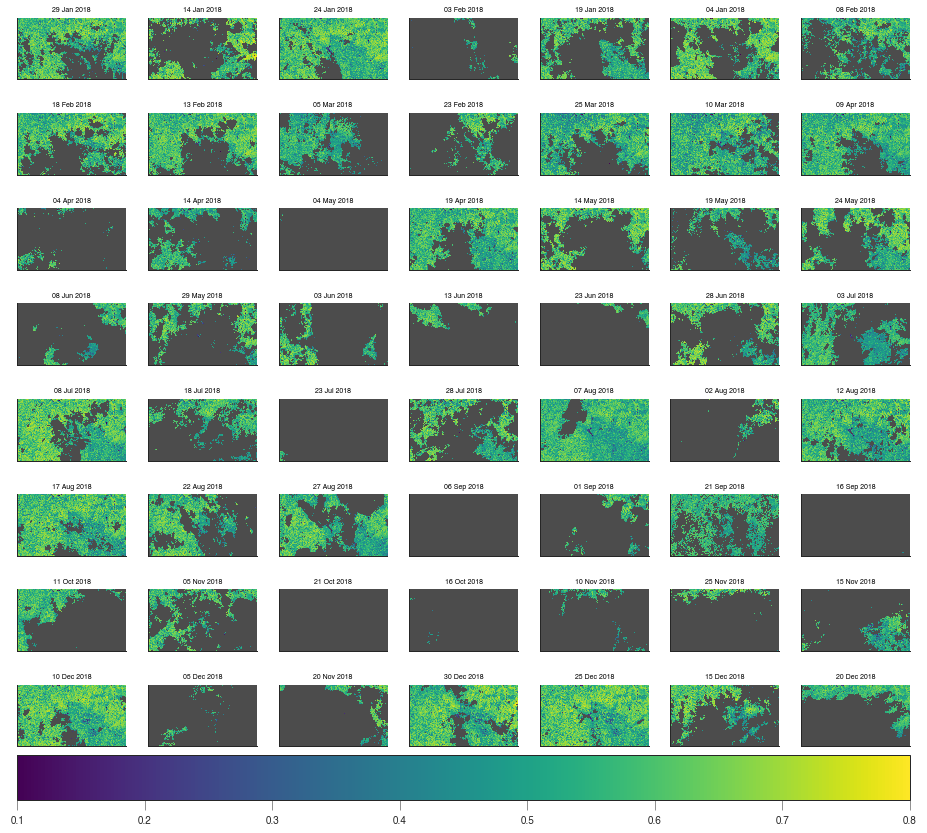

In [8]:

fig, axs = plt.subplots(nrows=8, ncols=7, sharex=True, sharey=True, figsize=(16,16))
axs = axs.flatten()
cmap=plt.cm.viridis
cmap.set_bad("0.3")
for ii, (k,v) in enumerate(analysis_data.items()):
    im =axs[ii].imshow(v, interpolation="nearest", vmin=0.1, vmax=0.8, )
    axs[ii].set_title(k.strftime("%d %b %Y"), fontsize=7)
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])
fig.colorbar(im, ax=axs.tolist(), orientation="horizontal", pad=0.01)

En la imagen superior, las áreas enmascaradas por la máscara de nubes aparece en gris. Es un poco complicado entender que está pasando aquí, pero a lo mejor las cosas se aclaran visualizando la distribución del índice como una serie temporal. Aunque la caja selecciona un poco de todo, así que tampoco nos hagamos muchas ilusiones!

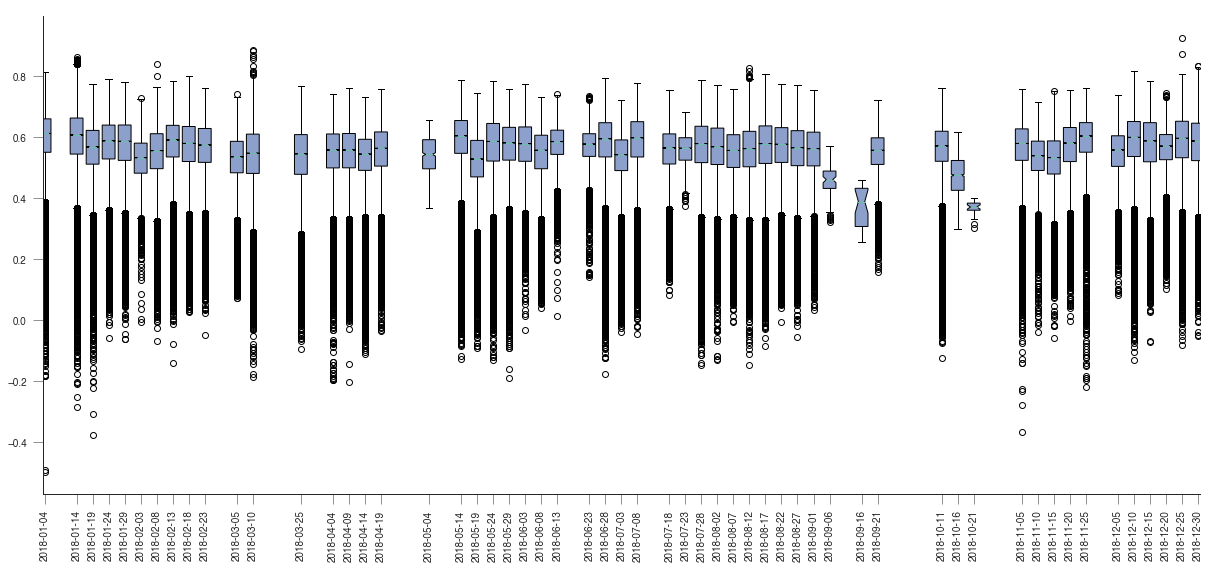

In [9]:
data = []
doys = []
tx = []
for ii, (k,v) in enumerate(analysis_data.items()):
    tx.append(k)
    doys.append(int(k.strftime("%j")))
    mask = np.isfinite(v.flatten())
    data.append(v.flatten()[mask])
isort = np.argsort(tx)
doys = [doys[i] for i in isort]
tx = [tx[i] for i in isort]
data = [data[i] for i in isort]
plt.figure(figsize=(17,8))    
bp = plt.boxplot(data, positions=doys, notch=True, widths=4,
                 meanline=True, patch_artist=True, labels=tx)
_ = plt.xticks(rotation="vertical")
_ = [patch.set_facecolor("#8DA0CB") for patch in bp['boxes']]
plt.tight_layout()

Vemos que el valor del índice está centrado alrededor de 0.5-0.6, y es difícil ver una tendencia. 